# Implementação do algoritmo de Regularização de LASSO

Para este projeto sera usado o Boston dataset onde o objetivo e prever a variável **MEDV** que é o valor médio das casas ocupadas pelos proprietários em US$ 1000.

Existem 14 atributos em cada caso do conjunto de dados. Eles são:

* `CRIM` - taxa de criminalidade per capita por cidade.
* `ZN` - proporção de terrenos residenciais divididos em lotes com mais de 25.000 pés quadrados.
* `INDUS` - proporção de acres comerciais não comerciais por cidade.
* `CHAS` - variável fictícia Charles River (1 se o trecho limita o rio; 0 caso contrário).
* `NOX` - concentração de óxidos nítricos (ações por 10 milhões).
* `RM` - número médio de quartos por moradia.
* `AGE` - proporção de unidades ocupadas pelos proprietários construídas antes de 1940.
* `DIS` - distâncias ponderadas a cinco centros de emprego em Boston.
* `RAD` - índice de acessibilidade às rodovias radiais
* `TAX` - taxa de imposto sobre a propriedade de valor total por US10.000.
* `PRATIO` - proporção aluno-professor por cidade.
* `B-1000` - (Bk - 0,63) ^ 2 onde Bk é a proporção de negros por cidade.
* `LSTAT` - % menor status da população.
* `MEDV` - Valor médio das casas ocupadas pelos proprietários em US 1000.
    
Para mais detalhes consultar o [link](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Data Mining
import pingouin as pg
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset
dataset = 'boston-housing.csv'

df = pd.read_csv(dataset)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    float64
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [3]:
# Checando as primeiras linhas do conjunto de dados
df.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


Para começar nossa análise vamos ver a distribuição da variável alvo através de um histograma

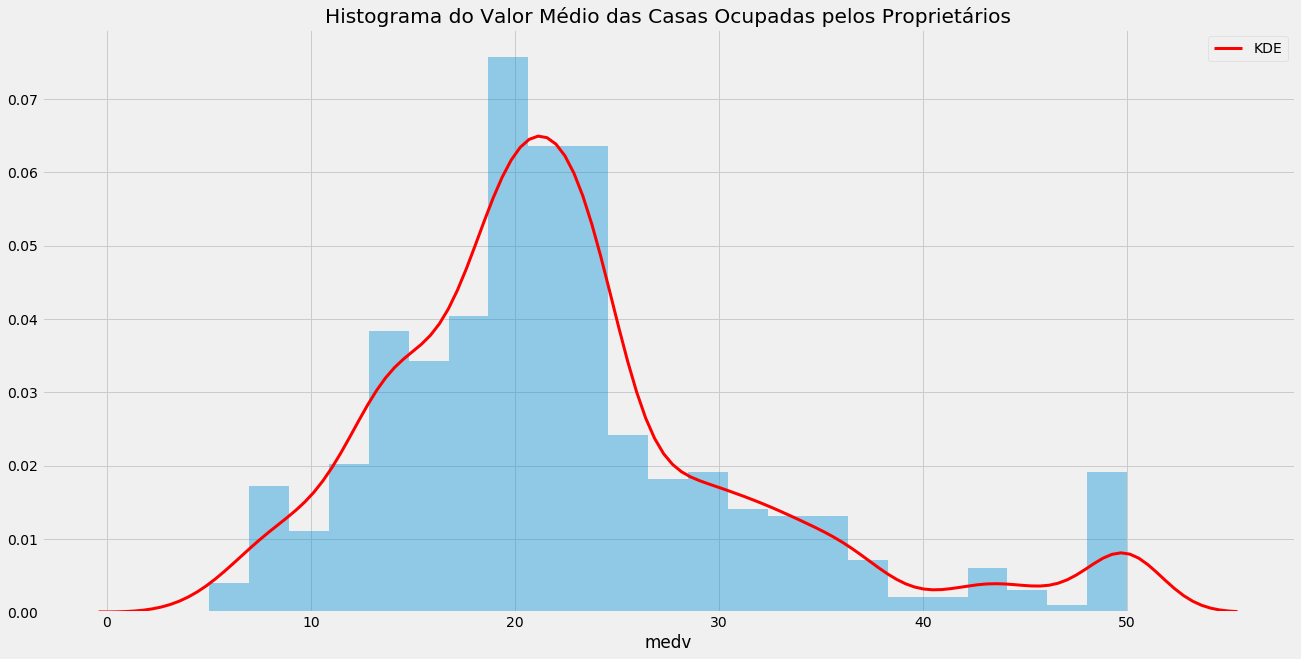

In [4]:
# Histograma e density plot para a variável 'MEDV'
sns.distplot(df['medv'], 
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma do Valor Médio das Casas Ocupadas pelos Proprietários')
plt.show()

Fica claro por meio da distribuição da variável **"MEDV"** que a mesma não possui uma distruibuição normal, para confrontar isso vamos olhar para seu **qq plot** para saber termos a certeza.

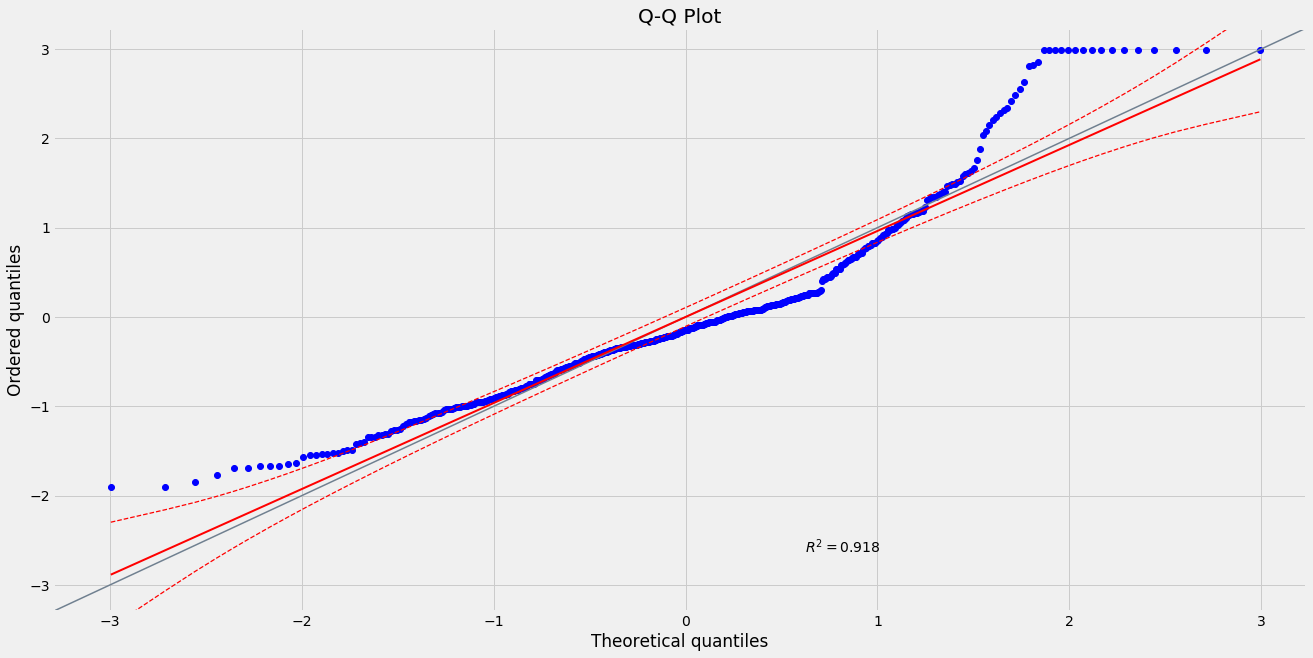

In [5]:
# Cria o gráfico
pg.qqplot(df['medv'], 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

Pelo gráfico primeiro e possivel ver que a variável **'MEDV'** possui uma assimétria a direita, e o gráfico de probabilidade mostra que os dados possuem uma distorção principalmente na sua cauda direita, não se adequando na curva normal, outro sinal de assimetria nos dados.

Para se obter uma melhores previsões a respeito da variável alvo vamos transformar a mesma com ajuda da função `boxcox` do pacote **Scipy** 

In [6]:
# Aplicando boxcox na variável MEDV
df['medvb'], lam_value = stats.boxcox(df['medv'])
print('O valor de lambda ideal é: ', lam_value)

O valor de lambda ideal é:  0.2166209012915364


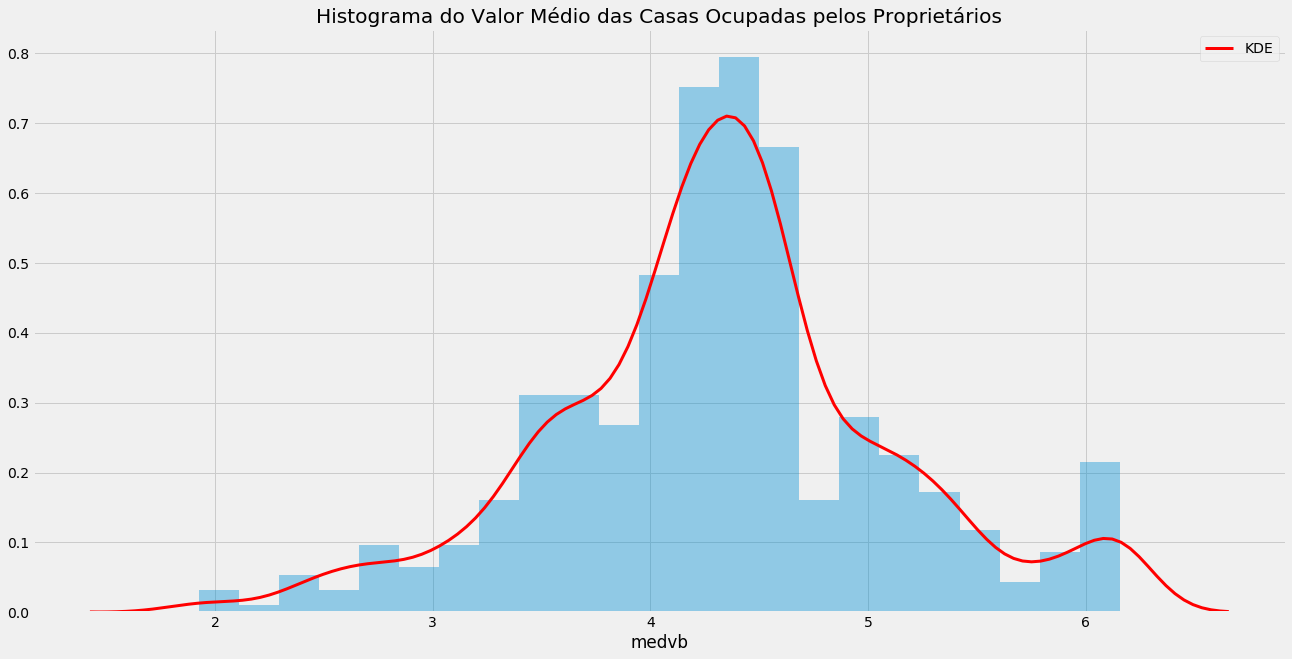

In [7]:
# Histograma e density plot para a variável 'MEDV'
sns.distplot(df['medvb'], 
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma do Valor Médio das Casas Ocupadas pelos Proprietários')
plt.show()

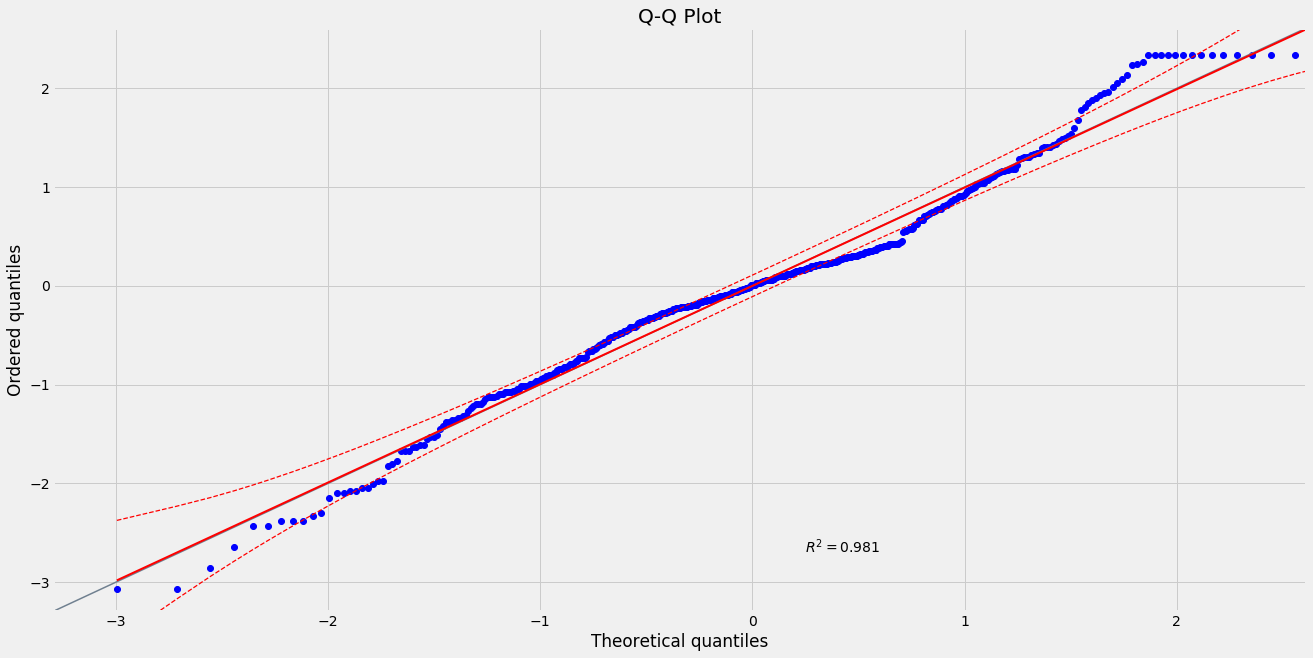

In [8]:
# Cria o gráfico
pg.qqplot(df['medvb'], 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

Depois de transformada podemos ver que o histograma esta mais centralizado e por meio do qq-plot vemos que a mesma esta de certa forma mais comportada pois os valores tendem a estar dentro do intervalo de confiação e tambem o **R²** é bem alto **0.981**.

Agora que observamos a variável alvo mais de perto, vamos examinar o único atributo categórico presente no dataset a variável **"CHAS"** por meio de um gráfico de barras.

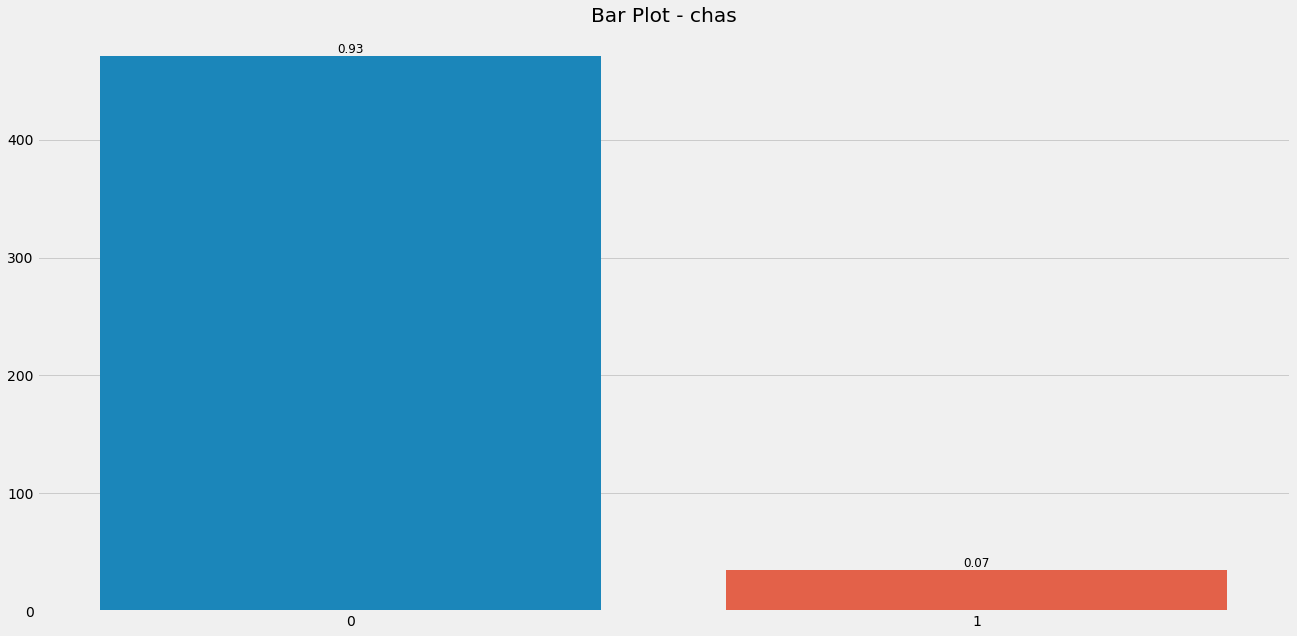

In [9]:
# Cria o novo gráfico de barras da variável "Churn"
ax = sns.barplot(x=df['chas'].value_counts().index, 
                 y=df['chas'].value_counts().values,
                 data=df)

total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height, '{:1.2f}'.format(height/total), 
            fontsize=12, color='black', ha='center', va='bottom')

plt.title('Bar Plot - chas')
plt.show()

Pelo gráfico podemos ver que a variável é bem desbalanceada. Para tentarmos entender um pouco melhor como se da o relacionamento desta variável com a variável alvo **"MEDV"**, vamos observar como a um histograma da variável alvo segmentado por meio desta variável.

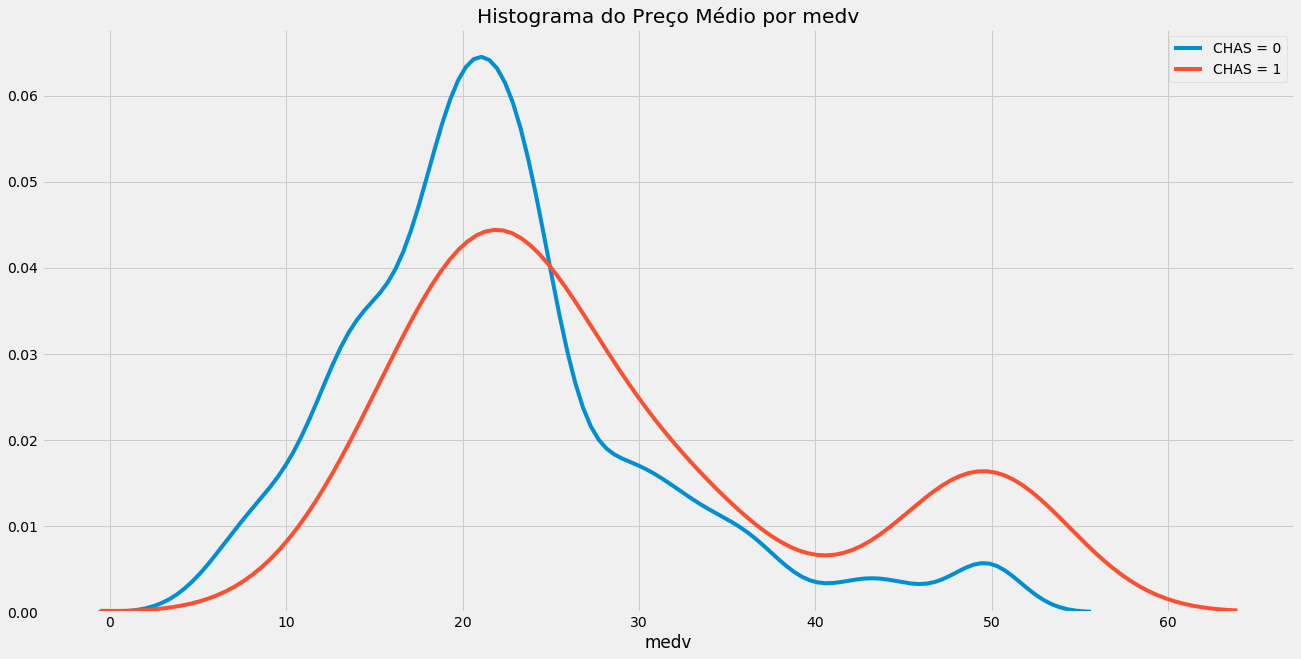

In [10]:
# Histograma da variável "Preço" com base nos clientes que tiveram sentimentos positivos
chas_0 = df[df['chas'] == 0]
sns.distplot(chas_0['medv'], 
             hist=False, 
             kde=True, 
             label='CHAS = 0')

# Histograma da variável "Preço" com base nos clientes que tiveram sentimentos Neutros
chas_1 = df[df['chas'] == 1]
sns.distplot(chas_1['medv'], 
             hist=False, 
             kde=True, 
             label='CHAS = 1')

# Plota o histograma
plt.title('Histograma do Preço Médio por medv')
plt.show()

Semelhante ao gráfico de de barras visto anteriormente e possível ver que o imóvel com valor de **1** estão em uma menor quantidade porém possuem uma média de preço mais alta. Para checar isso vamos finalizar a análise no atributo **"CHAS"** por meio da observação de um box-plot do atributo alvo segmentado pela a variável categórica.

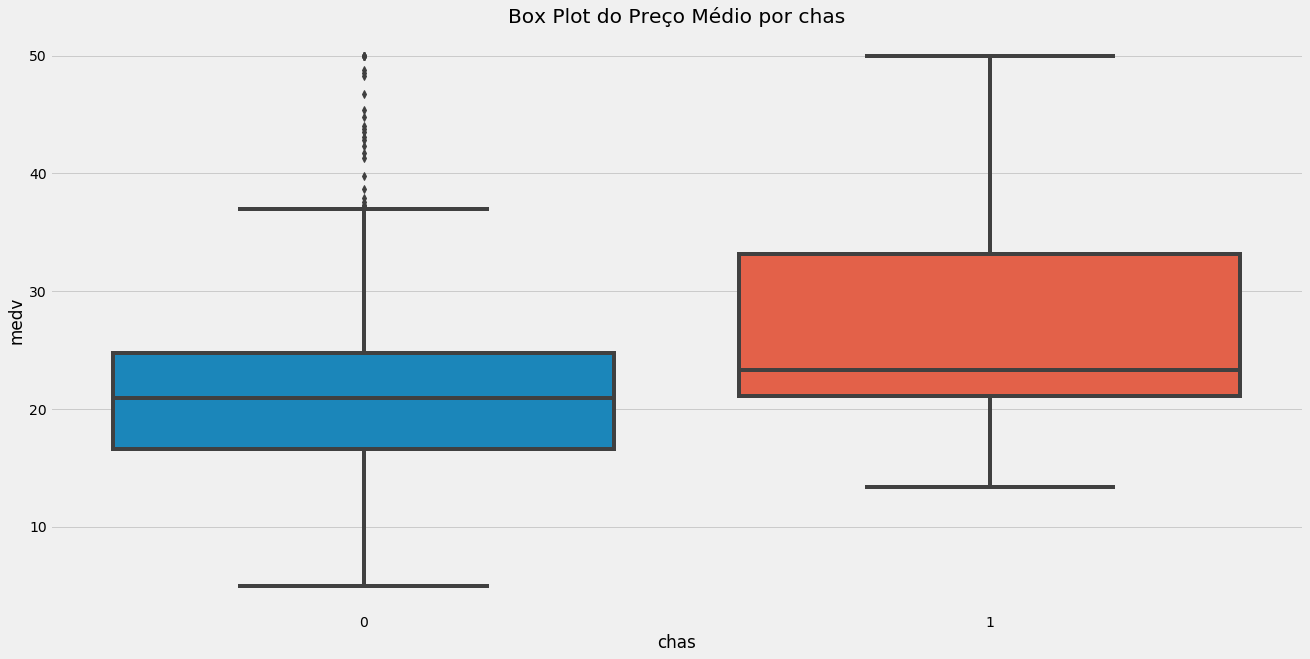

In [11]:
# Box-Plot do Preço em relação aos sentimentos
sns.boxplot(x='chas', 
            y='medv', 
            data=df)

# Plota o gráfico
plt.title('Box Plot do Preço Médio por chas')
plt.show()

Fica evidente por meio dos box-plot que imóveis classificados com valores igual a 1 possuem um preço médo maior do que aqueles classificados como igual  a zero, mesmos estes possuindo muitos valores extremos.

Dando sequência na análise exploratória vamos examinar a agora as variáveis quantitavas presentes no conjunto de dados. Primeiramente vamos observar as estatísticas descritivas desses atributos.

In [12]:
# Sumário estístico das variáveis quantitativas
quant_cols = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 
              'rad', 'tax', 'ptratio', 'black', 'lstat']

df[quant_cols].describe()

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,black,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Agora que sabemos algumas das estatísticas descritivas desses atributos, vamos observar o relacionamento de cada uma dessas variáveis com a variável alvo "MEDV" por meio de um scatter plot.

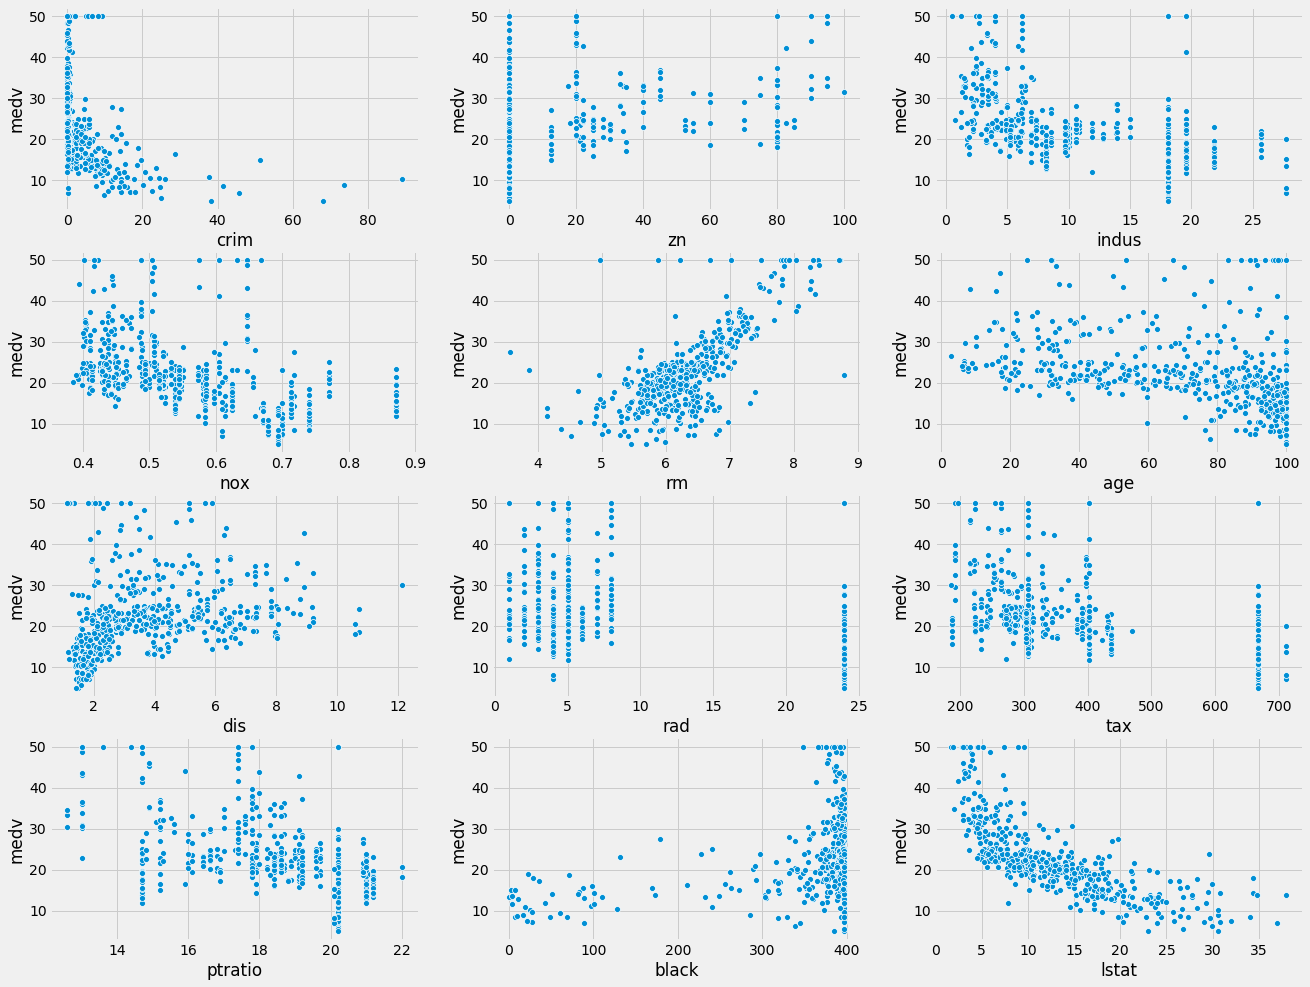

In [13]:
# Define os subplots das variáveis quantitativas contra a variável "MEDV"
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o scatter plot
for ax, scatter in zip(axes, df[quant_cols]):
    sns.scatterplot(x=scatter, 
                    y=df['medv'], 
                    ax=ax, 
                    data=df)

# Mostra o gráfico
plt.show()

Agora que conhecemos os relacionamentos dessas variáveis com a variável target, vamos descobrir o relacionamento dessas mesmas variáveis umas com as outras, por meio de um scatter matrix. A utilização de um scatter matrix nos ajuda a descobrir se é possível observa algum grau de colineariedade entre essas variáveis. 

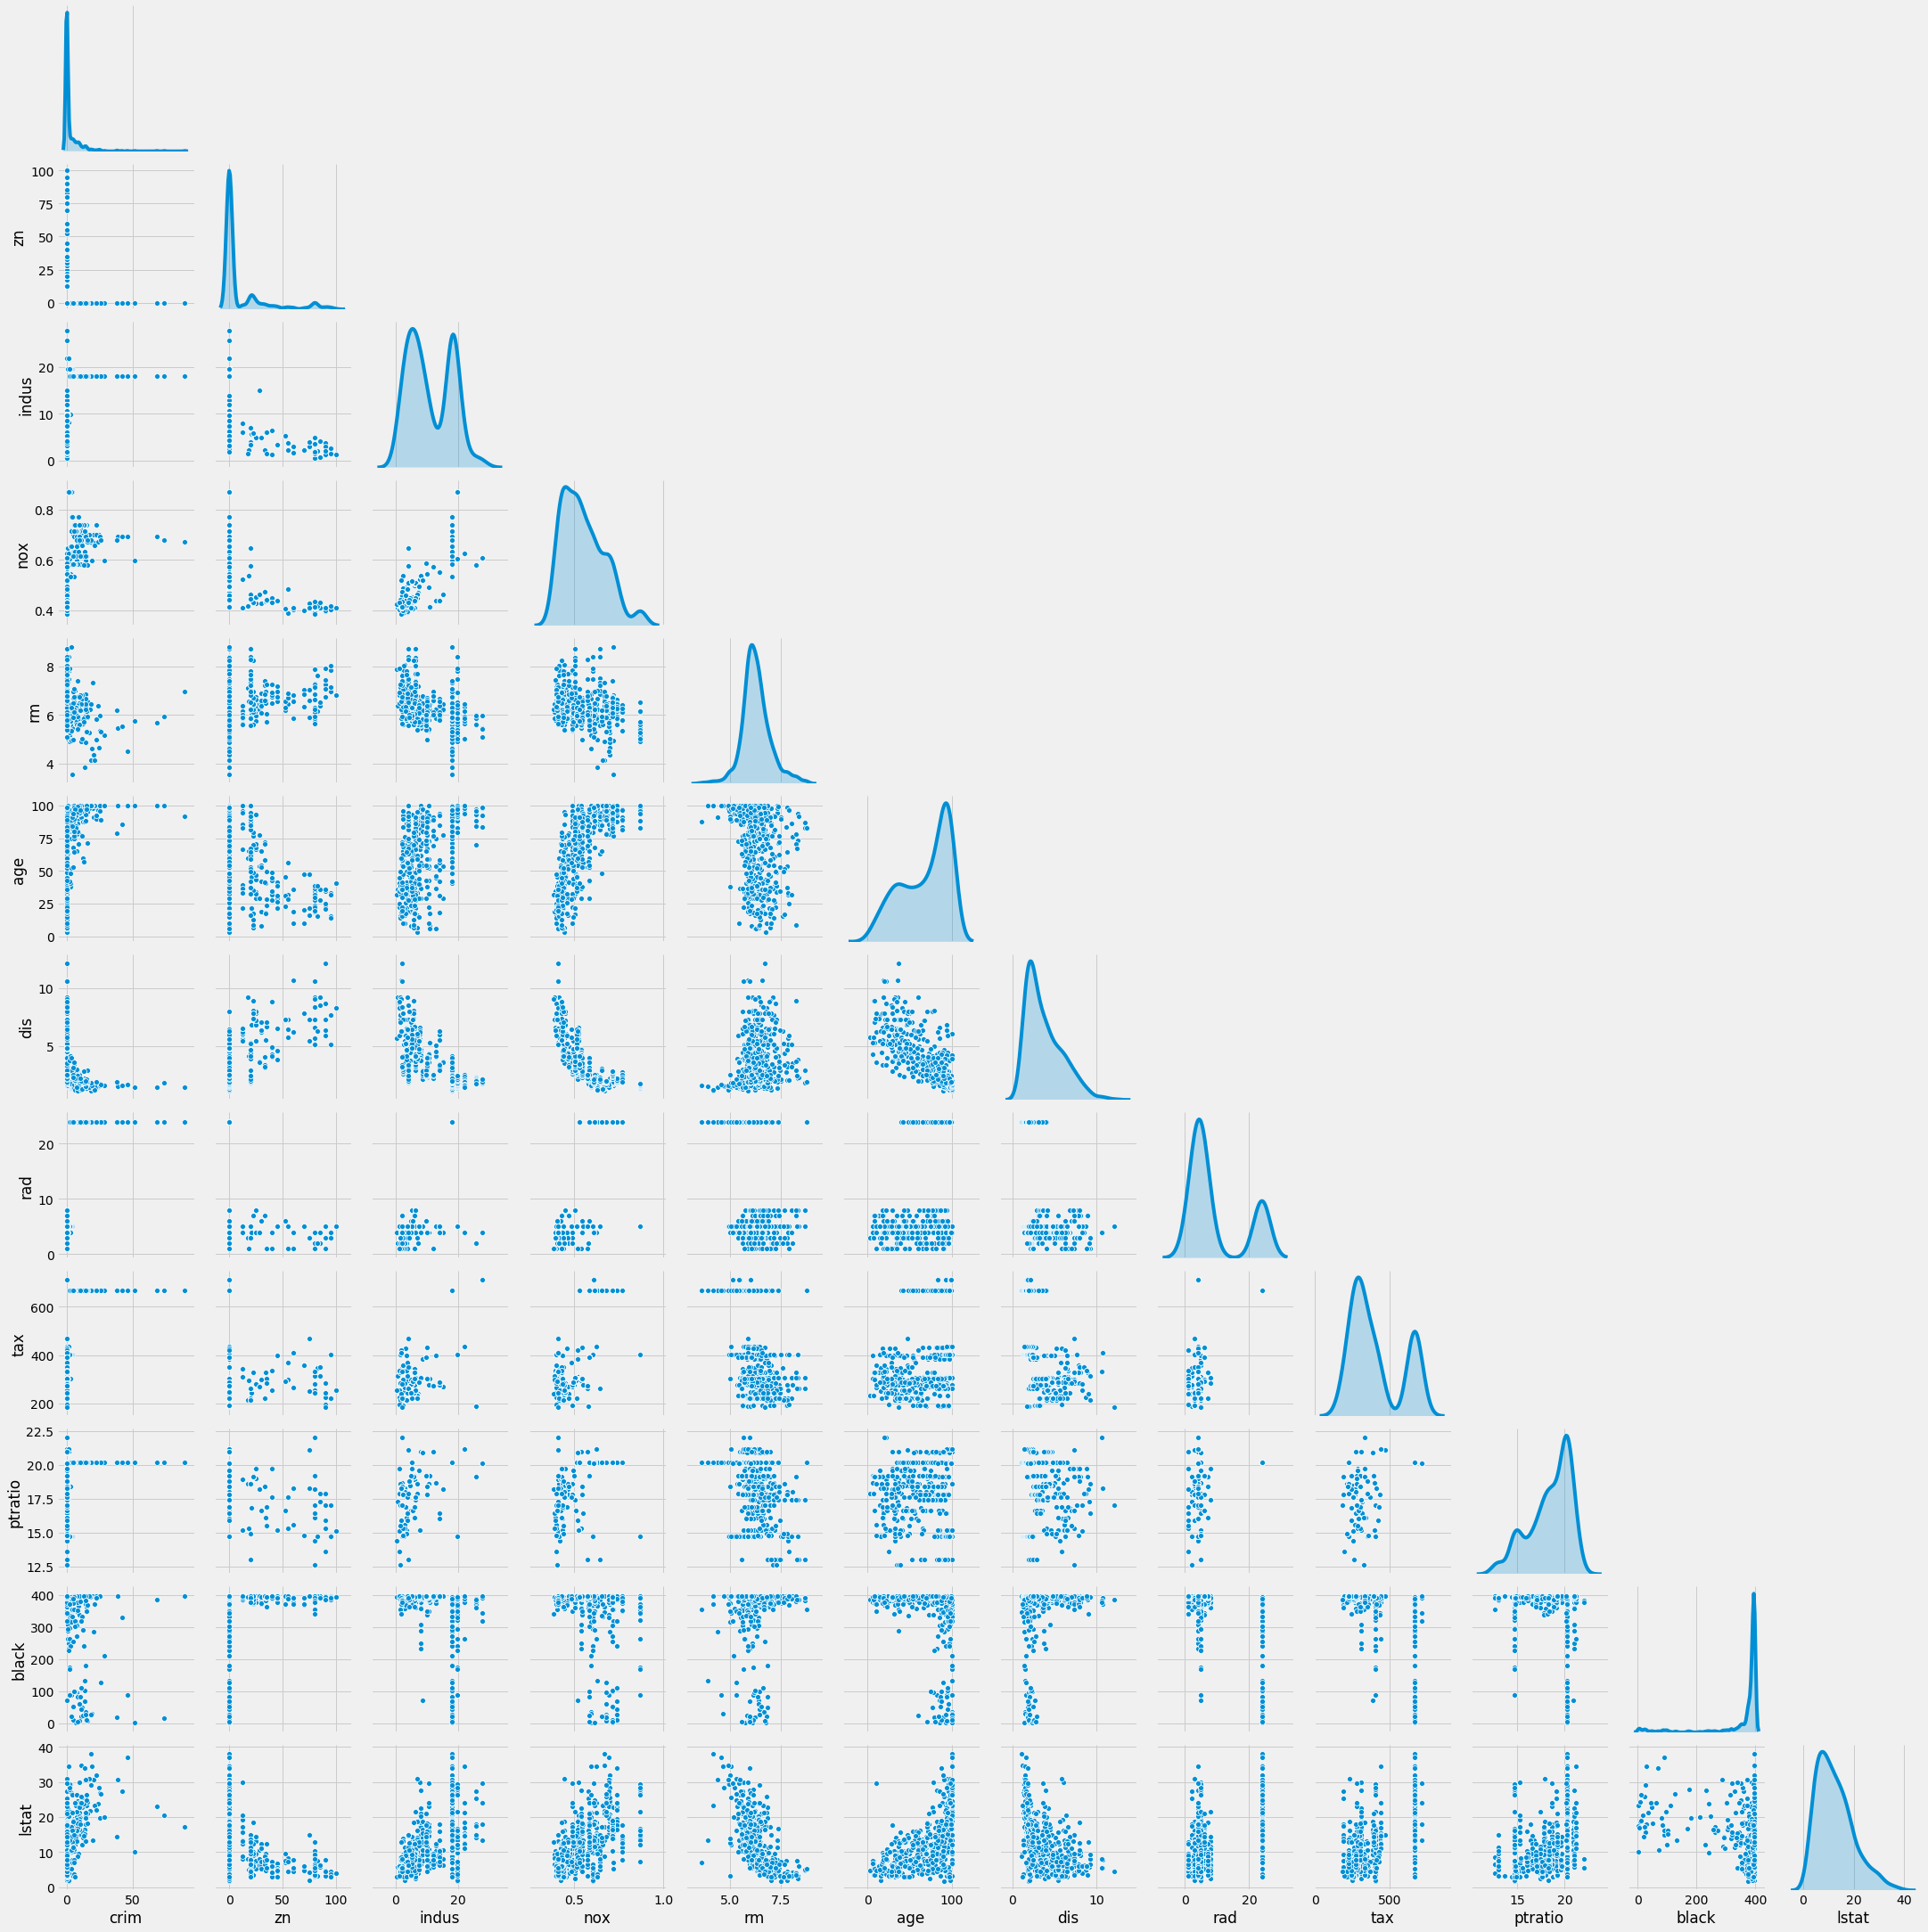

In [14]:
# Visualizando as relações entre as variáveis quantitativas através de gráfico dispersão
sns.pairplot(df, 
             vars=df[quant_cols], 
             diag_kind='kde', 
             corner=True)

# Mostra o gráfico
plt.show()

Uma outra maneira, até mais facil de tentar indentificar colineariedade entre as variáveis é através de uma matriz de correlação. Na matriz de correlação aplicamos uma tipo de correlação (nesse caso correlação de pearson), a cada uma das variáveis uma contra a outra, as cores mais quentes significam uma relação mais positiva enquanto as mais frias indicam uma correlação negativa.

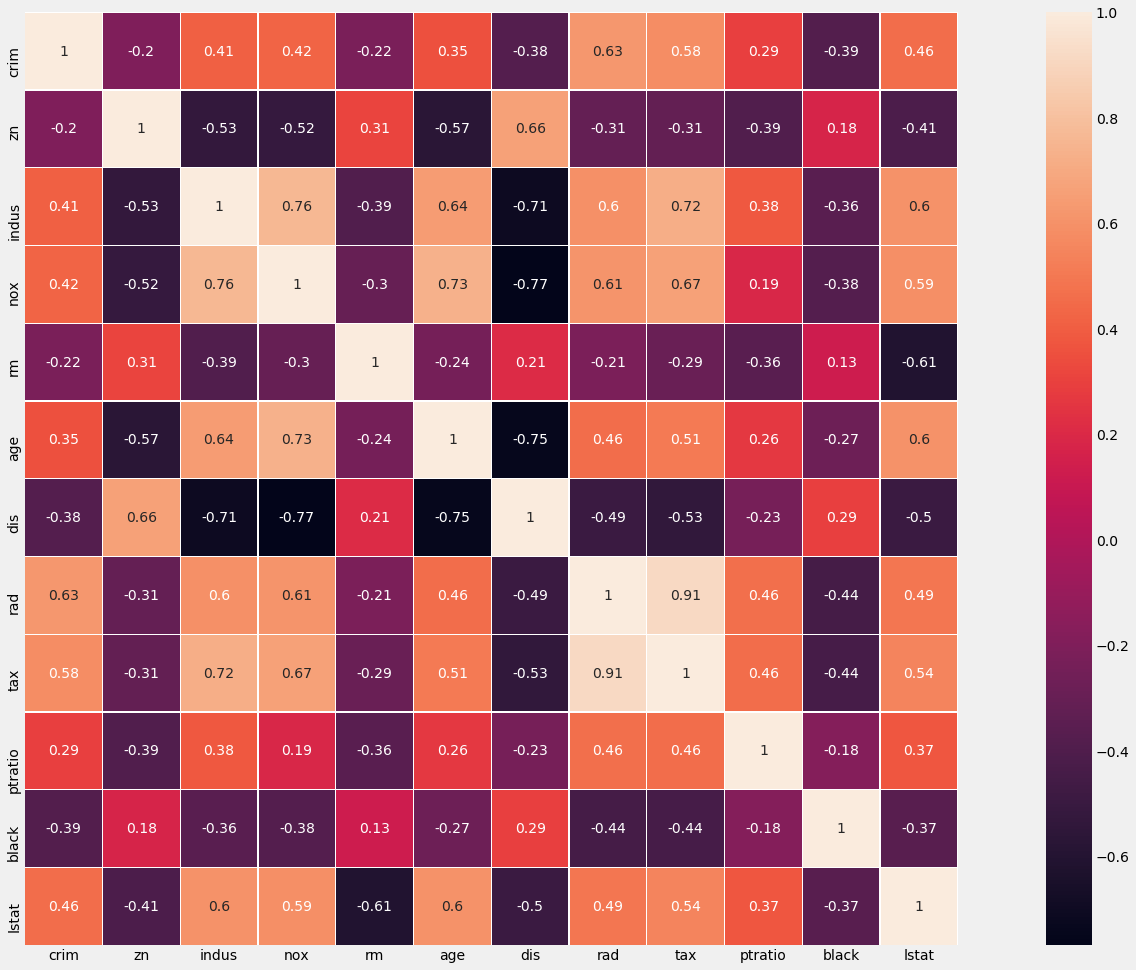

In [15]:
# Define o tamanho da figura
plt.figure(figsize=(28, 16))

# Cria uma matrix de correlação dos atributos categóricos
sns.heatmap(df[quant_cols].corr(method='pearson'), 
            annot=True, 
            linewidths=0.3, 
            square=True)

# Mostra o gráfico
plt.show()

Com a matriz de correlação já se nota uma grande diferença em comparação a um pairplot, porém para se ter a certeza da multicolinearidade entre as variáveis e necessário aplicar um método conhecido como **VIF** (**Variance Inflation Factor**), porém como neste projeto o objetivo principal se trata da construção e implementação de um algortimo de Regresão de LASSO a partir do zero, aplicação deste método foge do objtivo principal.

Agora para finalizar a análise a análise exploratoria dos atributos quantitativos vamos procurar entender os outliers presentes nessas variáveis através dos seus respectivos box e violin plots.

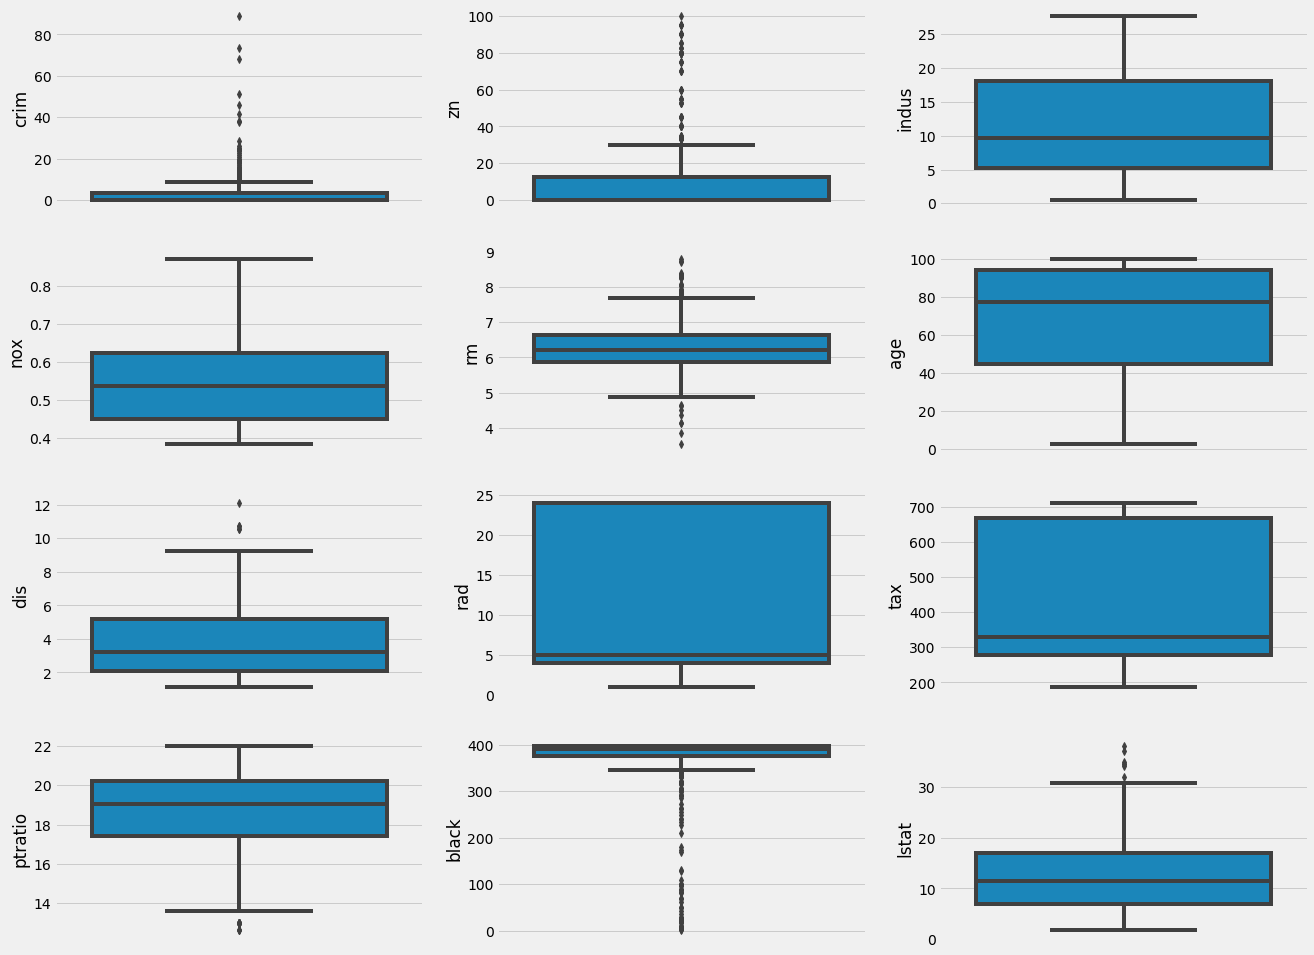

In [16]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o box plot
for ax, box in zip(axes, df[quant_cols]):
    sns.boxplot(y=box, 
                ax=ax, 
                data=df)

# Mostra o gráfico
plt.show()

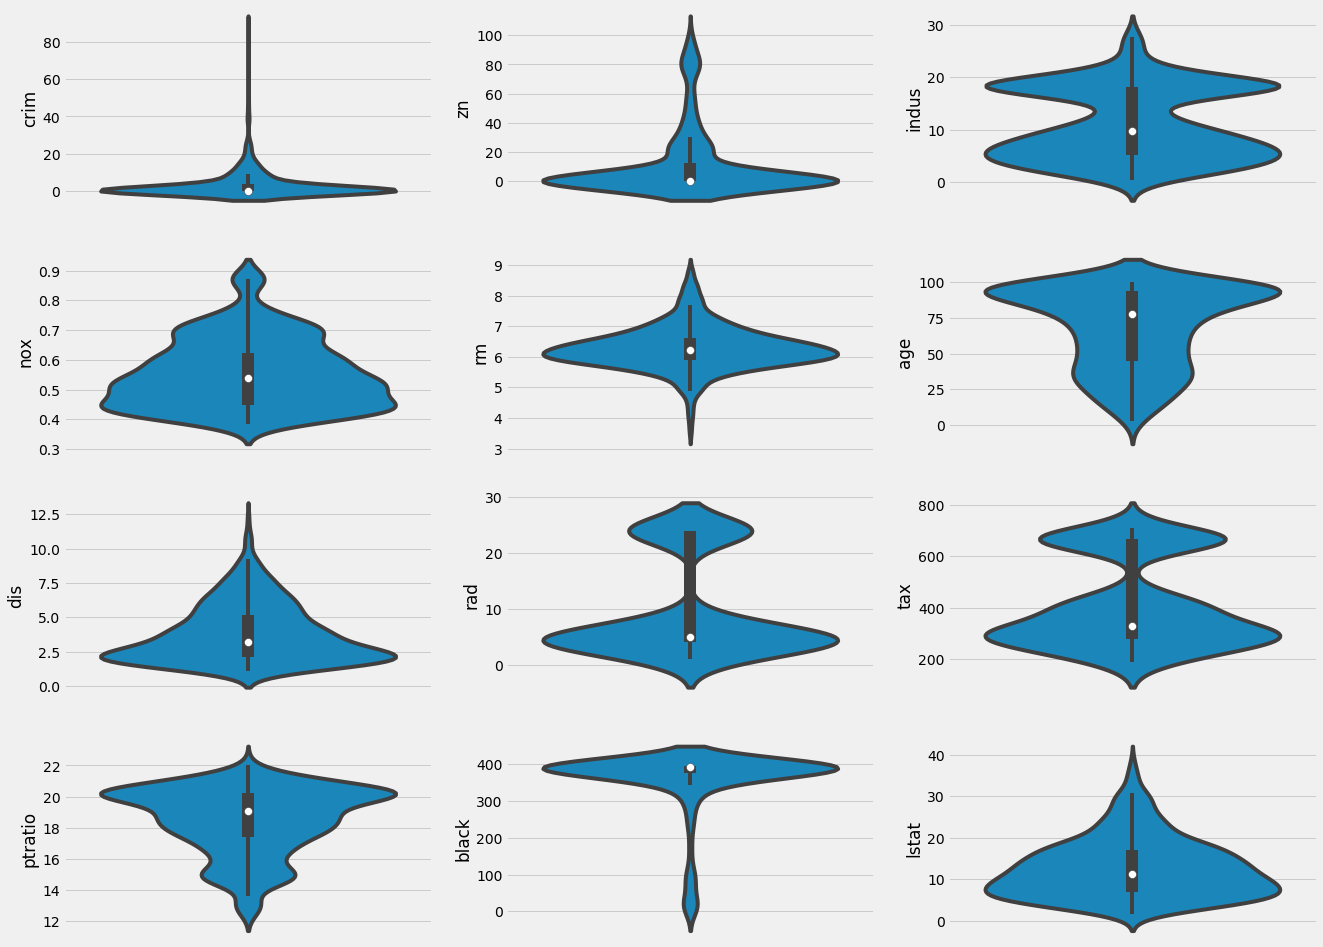

In [17]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o violin plot
for ax, violin in zip(axes, df[quant_cols]):
    sns.violinplot(y=violin, 
                   ax=ax, 
                   data=df)

# Mostra o gráfico
plt.show()

Por meio dos dois gráficos é possível enxergar que alguns atributos possuem muitos valores outliers. Para tentar corrigir este problema vamos substituir os valores outliers através da substituição do **0.05** e **.95** percentil de cada uma das respectivas variáveis.

In [18]:
# Selecionando o 95º quantil das variáveis
upper_quantiles = df[['crim', 'zn', 'rm', 'dis', 'ptratio', 'black', 'lstat']].quantile(.95)
upper_quantiles

crim        15.78915
zn          80.00000
rm           7.58750
dis          7.82780
ptratio     21.00000
black      396.90000
lstat       26.80750
Name: 0.95, dtype: float64

In [19]:
# Selecionando os dados que são maiores que o 95º quantil
outliers = (df[['crim', 'zn', 'rm', 'dis', 'ptratio', 'black', 'lstat']] > upper_quantiles)

# Seleciona as colunas com outliers
outliers_vars = ['crim', 'zn', 'rm', 'dis', 'ptratio', 'black', 'lstat']

# Substituindo os outliers pelo 95º quantil de cada variável
for i in outliers:
    df[outliers_vars] = df[outliers_vars].mask(outliers, upper_quantiles, axis=1)

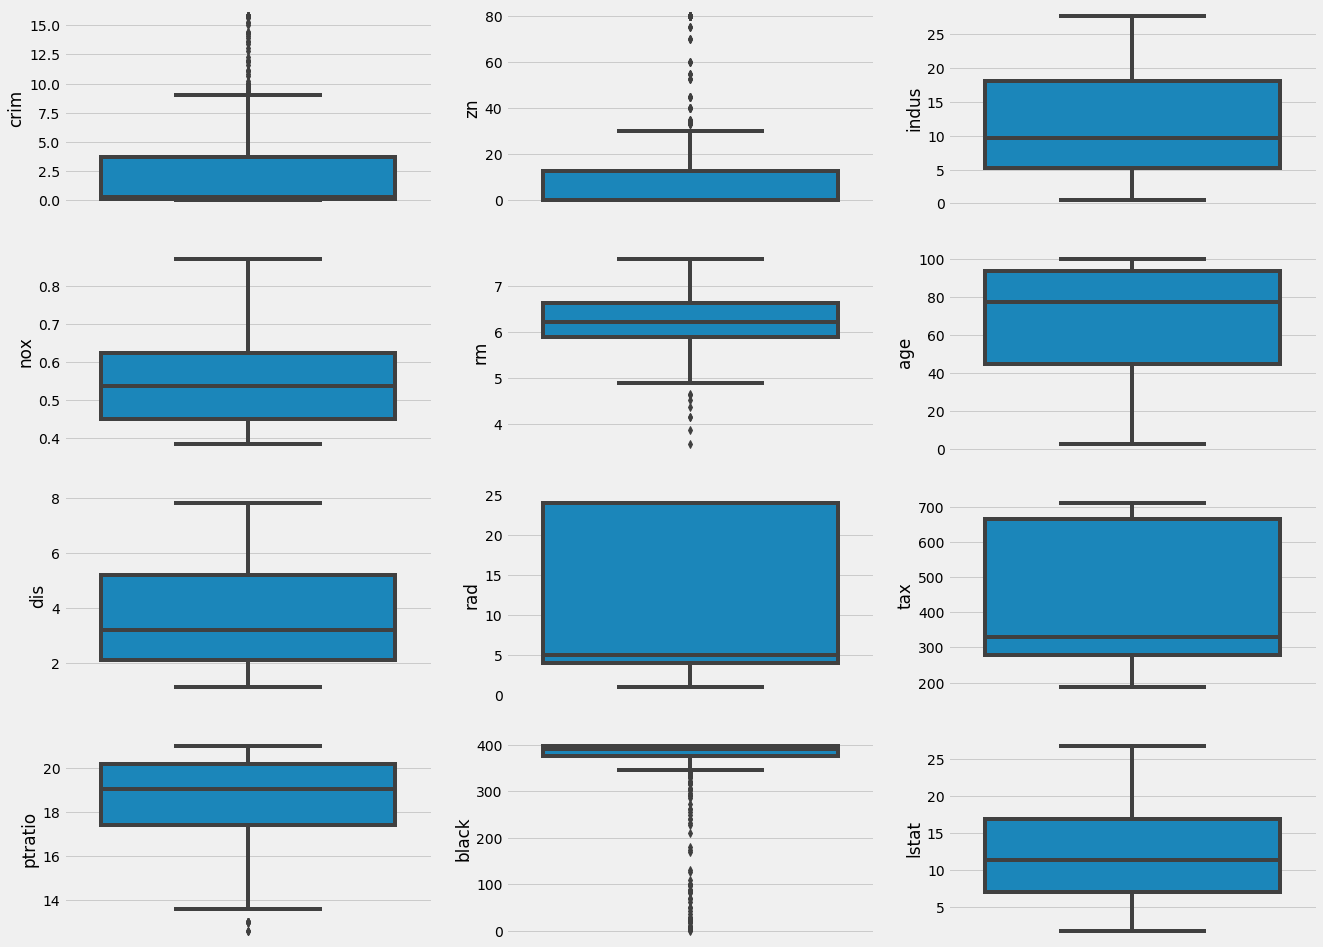

In [20]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o box plot
for ax, box in zip(axes, df[quant_cols]):
    sns.boxplot(y=box, 
                ax=ax, 
                data=df)

# Mostra o gráfico
plt.show()

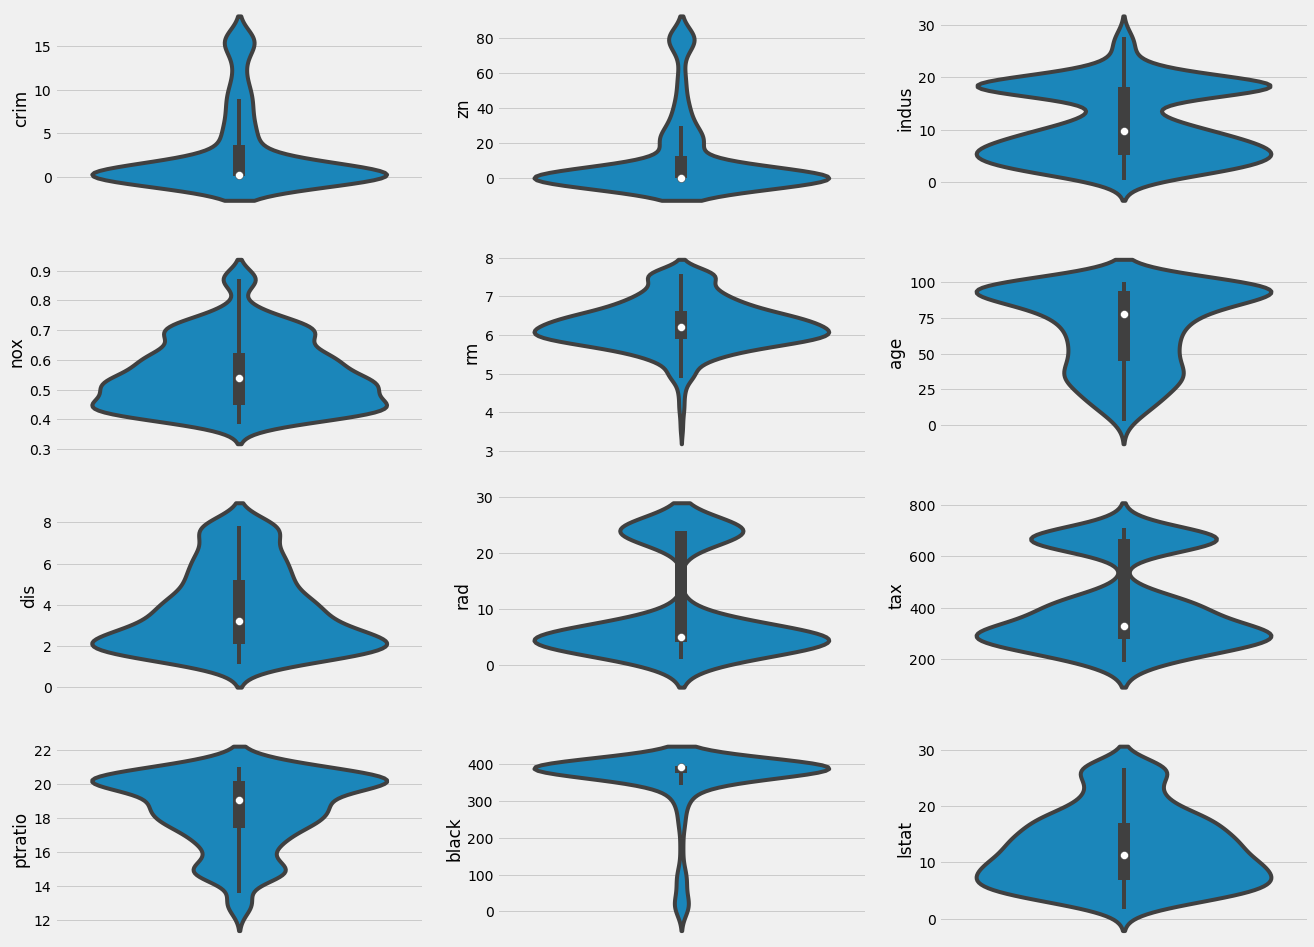

In [21]:
# Conjunto de box-plots das variáveis quantitativas
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o violin plot
for ax, violin in zip(axes, df[quant_cols]):
    sns.violinplot(y=violin, 
                   ax=ax, 
                   data=df)

# Mostra o gráfico
plt.show()

Algumas variáveis parecem ser assimétricas, principalmente a variável target **'MEDV'**. 

Primeiro vamos olhar unicamente para seu histograma e seu density plot. Depois vamos checar assimétria de todos os atributos por meio do método skew do pandas.

In [22]:
# Assimetria das variáveis
df.skew()

crim       1.754791
zn         2.121909
indus      0.295022
chas       3.405904
nox        0.729308
rm        -0.155095
age       -0.598963
dis        0.703159
rad        1.004815
tax        0.669956
ptratio   -0.827153
black     -2.890374
lstat      0.593376
medv       1.108098
medvb      0.015882
dtype: float64

Alguns atributos parecem ter assimetria muito elevada e com isso não vão se adequar a curva normal e assim, o modelo aprensentara resultados ruins.

Quando as variáveis possuem uma assimétria muito elevada e não se adequam a curva normal podemos tentar fazer um aproximação de uma curva normal por meio da função `log1p` do pacote numpy.

In [23]:
# transformando os atributos
for col in df[quant_cols]:
    skew = stats.skew(df[col])
    if skew > 0.75:
        df[col] = np.log1p(df[col])

Vamos visualizar como ficou as variáveis quantitativas após estas tranformações, por meio de um `pairplot`.

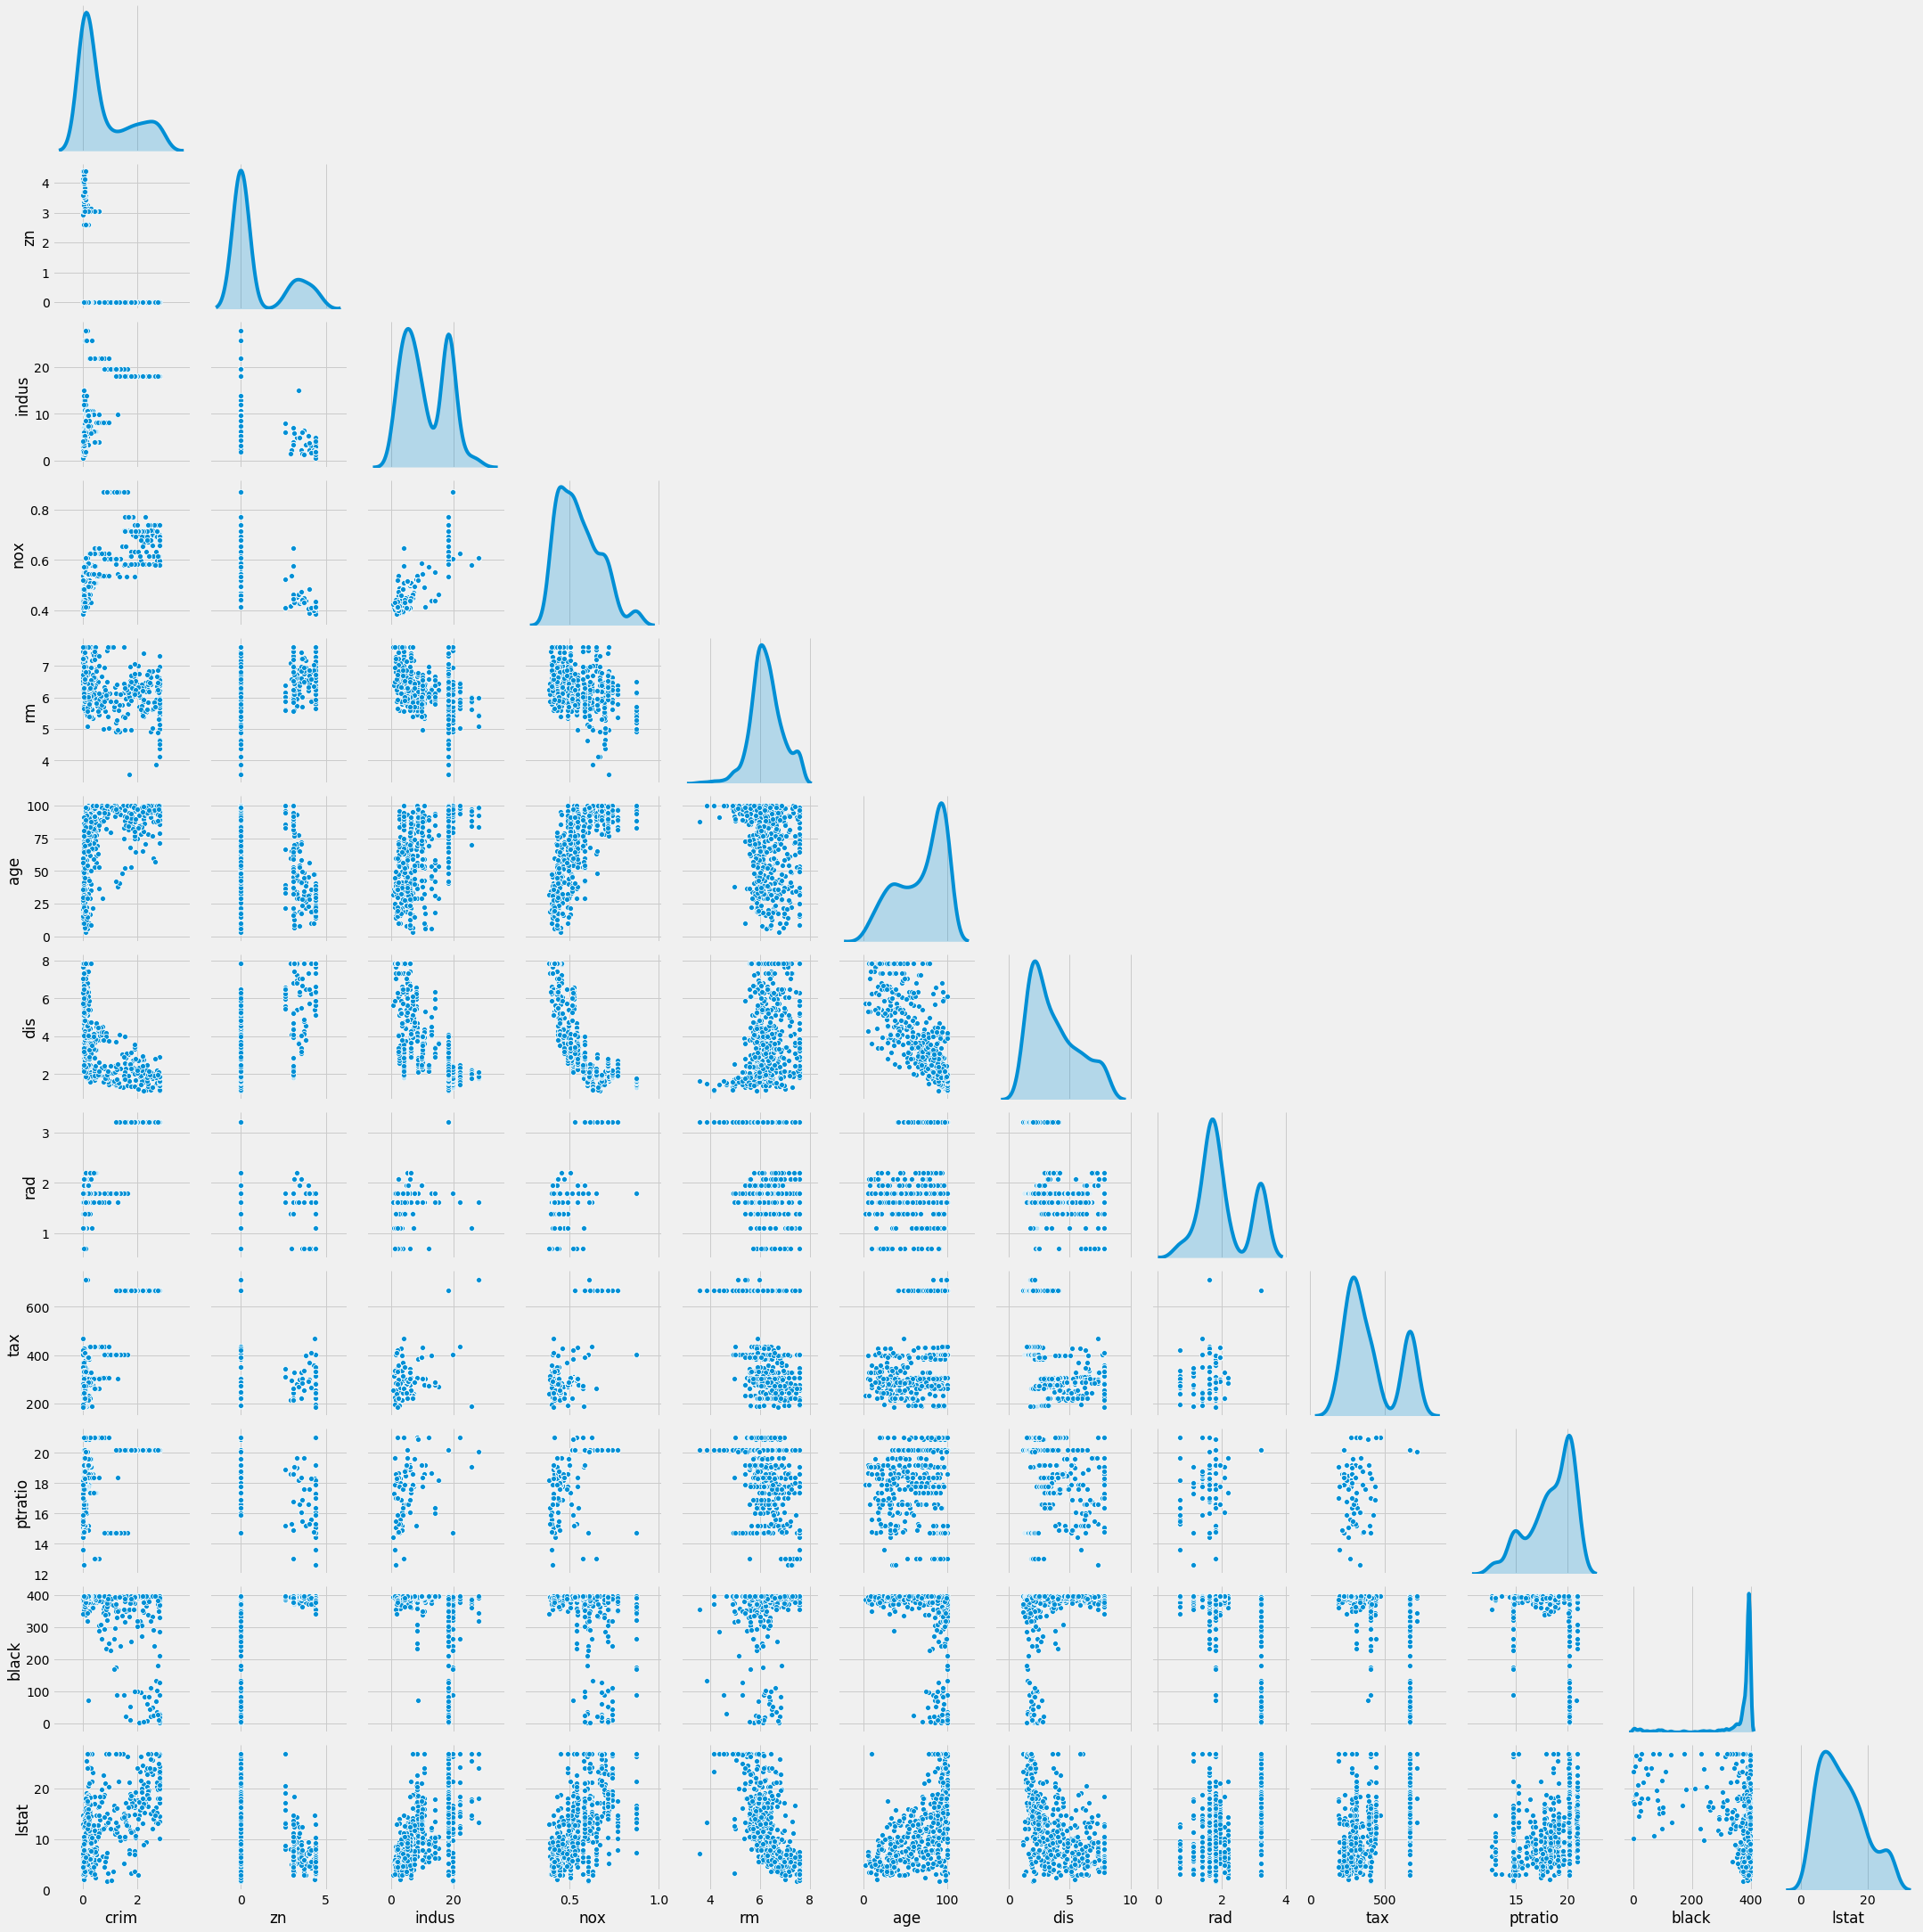

In [24]:
# Visualizando as relações entre as variáveis quantitativas através de gráfico dispersão
sns.pairplot(df, 
             vars=df[quant_cols], 
             diag_kind='kde', 
             corner=True)

# Mostra o gráfico
plt.show()

Antes de partir para criação do modelo de regressão vamos normalizar os dados, ou seja, coloca-lós em escala (no caso da normalização um range de 0 á 1), pois fará com que o modelo possua uma melhor performace.

O min-max scaler possui a seguinte formula:

$$\frac{X - X_{min}}{X_{max} - X_{min}}$$

In [25]:
# Normalizando os dados com Min-Max Scaler
df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))

# Visualizando o resultado
df_norm.head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,medvb
0,0.000000,0.670036,0.067815,0.0,0.314815,0.748541,0.641607,0.441969,0.000000,0.208015,0.321429,1.000000,0.129598,0.422222,0.625706
1,0.007335,0.000000,0.242302,0.0,0.172840,0.710294,0.782698,0.572915,0.160534,0.104962,0.619048,1.000000,0.295484,0.368889,0.576697
2,0.007328,0.000000,0.242302,0.0,0.172840,0.900037,0.599382,0.572915,0.160534,0.104962,0.619048,0.989737,0.091716,0.660000,0.806285
3,0.009081,0.000000,0.063050,0.0,0.150206,0.853595,0.441813,0.736407,0.274435,0.066794,0.726190,0.994276,0.048250,0.631111,0.786907
4,0.021486,0.000000,0.063050,0.0,0.150206,0.890600,0.528321,0.736407,0.274435,0.066794,0.726190,1.000000,0.143555,0.693333,0.827951
5,0.008212,0.000000,0.063050,0.0,0.150206,0.712529,0.574665,0.736407,0.274435,0.066794,0.726190,0.992990,0.138770,0.526667,0.711502
6,0.027824,0.592268,0.271628,0.0,0.286008,0.608717,0.656025,0.661506,0.434968,0.236641,0.309524,0.996722,0.426677,0.397778,0.603744
7,0.045733,0.592268,0.271628,0.0,0.286008,0.648454,0.959835,0.719731,0.434968,0.236641,0.309524,1.000000,0.694647,0.491111,0.683620
8,0.065855,0.592268,0.271628,0.0,0.286008,0.514094,1.000000,0.739378,0.434968,0.236641,0.309524,0.974104,1.000000,0.255556,0.456381
9,0.053559,0.592268,0.271628,0.0,0.286008,0.606730,0.854789,0.815518,0.434968,0.236641,0.309524,0.974305,0.612900,0.308889,0.516168


Tudo pronto agora vamos dividir o conjunto de dados em treino e teste para que possamos criar o algoritmo.

In [26]:
# Obtendo os valores do dataset
df = df_norm.values

# Dividindo o conjunto de dados em treino e teste
X = df[:, 0:12]
Y = df[:, 13]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## LASSO Regression

Least Absolute Shrinkage and Selection Operator Regression - LASSO é uma versão regularizada da Regressão Linear, ela adiciona um termo de regularização à função de custo mas utiliza norma $\ell_1$

A Regressão de LASSO elimina completamente os pesos dos coeficientes menos importantes. De outro modo a Regressão de LASSO executa automaticamente a seleção de características e exibe um modelo esparso, ou seja, com poucos pesos e caracterísicas diferentes de zero.

A função de custo de LASSO não é diferencial em $\theta_i = 0$ (para todo $i = 1, 2, \dots, n)$, mas o Gradiente Descendente ainda funciona bem se utilizarmos o vetor subgradiente $g$ quando qualquer $\theta_i$ for igual a 0.

Função custo da Regressão de LASSO

$$J(\theta) = \frac{1}{2 * n} \sum_{i=1}^{n} (\theta - \hat{\theta}) + \lambda {\sum}_{i=1}^n|{\theta}_i|$$

Vetor subgradiente da Regressão de LASSO

$$g(\theta, J) = 
{\nabla}_\theta MSE(\theta) + 
\alpha 
\begin{pmatrix} 
sinal(\theta_1) \\
sinal(\theta_2) \\ 
\vdots \\ 
sinal(\theta_n)
\end{pmatrix}$$

$$\text{ onde } sinal(\theta_i) = 
\begin{cases}
-1 & \quad \text{if } \theta_i < 0 \\
0 & \quad \text{if } \theta_i = 0 \\
+1 & \quad \text{if } \theta_i > 0
\end{cases}$$

In [27]:
# Criando a classe
class LASSO(object):
    
    # Inicializando os parâmetros
    def __init__(self, l1_regularization, learning_rate, n_iterations):
        self.l1_regularization = l1_regularization
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
    
    # Definindo a função treino
    def fit(self, X, y):
        m, n = X_train.shape
        self.weights = np.random.randn(n) / np.sqrt(n)
        self.cost_function = []
        intercept = np.sum(y - np.dot(X, self.weights)) / m
        
        for i in range(self.n_iterations):
            
            yi = np.dot(X, self.weights)
            errors = y - yi
            mse = np.sum(0.5 * (errors**2)) + self.l1_regularization * np.sum(np.abs(self.weights))
            self.cost_function.append(mse)
            gradient = self.weights - (self.learning_rate * (X.T.dot(errors) + self.l1_regularization * np.sign(self.weights)))
            self.weights -= self.learning_rate * gradient
    
    # Definindo a função teste 
    def predict(self, X):
        return (np.dot(X, self.weights))

In [28]:
# Cria uma função com as métricas de avaliação
def performace(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return (print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAE das previsões é {}'.format(round(mae, 2))))

Agora vamos treinar e testar o modelo para observar se esta correto

In [29]:
# Criando o modelo e definindo os parâmetros
model = LASSO(l1_regularization=0.15, learning_rate=0.01, n_iterations=500)

# Treinando o modelo
model.fit(X_train, y_train)

# Realizando as previsões
predict = model.predict(X_test)

Agora vamos avaliar o modelo por meio de duas metricas muito utilizadas o Erro Quadrático Médio (MSE) e Erro Absoluto Médio (MAE).

O MSE basicamente mede o erro quadrado médio de nossas previsões. Para cada ponto, calcula a diferença quadrada entre as previsões e o valor real da variável alvo e, em seguida, calcula a média desses valores. O MSE e dado pela seguinte formula:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (y - \hat{y})^{2}$$

O MAE (Mean Absolute Error) é a soma da diferença absoluta entre previsões e valores reais. Fornece uma ideia de quão erradas estão nossas previsões. Valor igual a 0 indica que não há erro, sendo a previsão perfeita. O MAE e dado pela seguinte formula

$$MAE =  \frac{1}{n} \sum_{i=1}^{n} |y - \hat{y}|^{2}$$

In [30]:
# Erro Quadrático Médio para o modelo
performace(y_test, predict)

MSE das previsões é 0.03
RMSE das previsões é 0.16
MAE das previsões é 0.11


Agora apenas para comparação, vamos comparar os resultados modelo criado com modelos já prontos do scikit learn, para checar se os resultados são semelhantes. Primeiro vamos começar pela Regressão de Lasso e depois comparar o resultado com Stochastic Gradient Descent com regularização $\ell_1$.

In [31]:
# Instanciando o modelo
model = Lasso(alpha=0.05, random_state=42)

# Treina o modelo
model.fit(X_train, y_train)

# Realiza as Previsões
Lasso_pred = model.predict(X_test)

# Avalia a performace do modelo
performace(y_test, Lasso_pred)

MSE das previsões é 0.04
RMSE das previsões é 0.19
MAE das previsões é 0.14


### Referências

TIBSHIRANI, Robert. Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), v. 58, n. 1, p. 267-288, 1996.

GÉRON, Aurélien. Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.", 2017.